# Models

In [2]:
import numpy as np
import torch 
import math
import pandas as pd
import matplotlib.pyplot as plt

**Definition**

To allow unbiased comparison between frameworks, the following definition of the MSE loss was used:

\begin{equation}
C = \Sigma \| y(x) - a \| ^2
\end{equation}


## Framework 1: our framework

In [64]:
df_m1 = pd.read_json("loss_hugo.json")
df_m1.head()

,test_loss
0,0.709653
1,0.706177
2,0.699403
3,0.689369
4,0.675951


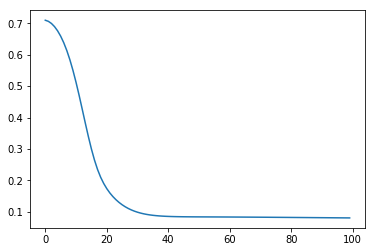

In [65]:
plt.plot(df_m1['test_loss'])

## Framework 2: M. Nielsen framework

In [36]:
#df_test = pd.read_json("test.json")
#df_test

In [12]:
n=1000
df_m2 = pd.read_json("all_params.json")
df_m2['train_accuracy'] = df_m2['train_accuracy'] / n
# Solve format problem
#for i in range(len)
#df_m2['test_accuracy'] = df_m2['test_accuracy'][1] / n
df_m2.head()

,train_cost,eval_cost,train_accuracy,test_accuracy
0,0.216555,0.274679,0.684,"[[314], [686]]"
1,0.218216,0.303609,0.684,"[[314], [686]]"
2,0.216287,0.292043,0.684,"[[314], [686]]"
3,0.218150,0.304520,0.684,"[[314], [686]]"
4,0.216550,0.296238,0.684,"[[314], [686]]"


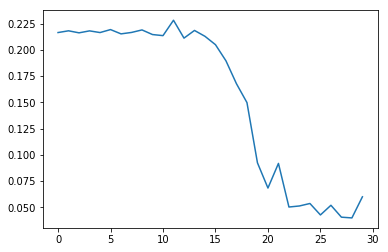

In [22]:
plt.plot(df_m2['train_cost'])

In [18]:
df_m2_2 = pd.read_json("100_epochs_2.json")
df_m2_2.shape

(100, 4)

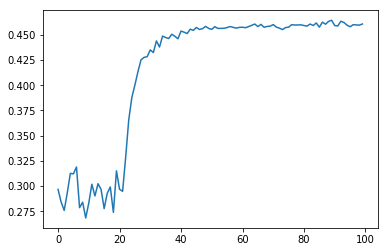

In [20]:
plt.plot(df_m2_2['eval_cost'])

Text(0.5, 1.0, 'Loss evolution during the training')

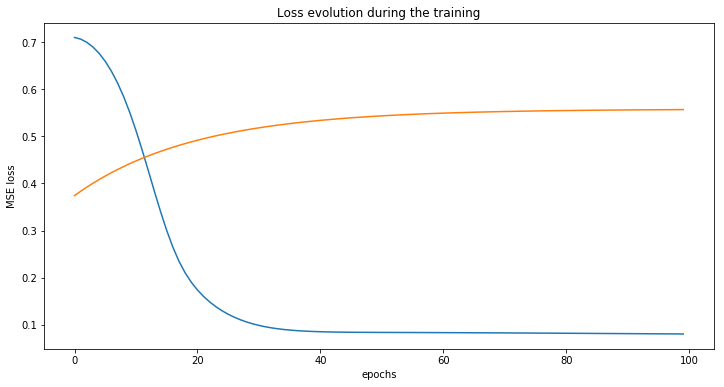

In [11]:
#sample = df_m2['train_accuracy']
#sample = sample[::2]
#plt.plot(df_m2['eval_cost'])
plt.subplots(figsize=(12, 6))
plt.plot(df_m1['test_loss'], label='Framework 1')
plt.plot(df_m2['eval_cost'], label='Framework 2')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.title('Loss evolution during the training')

In [38]:
# 100 epochs
df_100_epochs = pd.read_json("100_epochs.json")
df_100_epochs.head()

,train_cost,eval_cost,train_accuracy,test_accuracy
0,0.208028,0.299017,705,"[[342], [658]]"
1,0.207945,0.285550,705,"[[342], [658]]"
2,0.207669,0.288002,705,"[[342], [658]]"
3,0.212893,0.267446,705,"[[342], [658]]"
4,0.207603,0.299315,705,"[[342], [658]]"


## Framework 3: PyTorch 

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,25)
        self.fc2 = nn.Linear(25,25)
        self.fc3 = nn.Linear(25,25)
        self.fc4 = nn.Linear(25,2)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [12]:
def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [60]:
def train_model(model, train_input, train_target, mini_batch_size, monitor_loss=False):
    #mini_batch_size = 100
    
    criterion = nn.MSELoss()
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-2)
    # optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    nb_epochs = 1000
    
    loss_storage = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            
            sum_loss += loss.item() # compute loss for each mini batch for 1 epoch
            
            optimizer.step()
        
        if monitor_loss:
            loss_storage.append(sum_loss)
        
        print('[epoch {:d}] loss: {:0.2f}'.format(e+1, sum_loss))
    
    if monitor_loss:
        return loss_storage

#### Main

In [1]:
from torch.autograd import Variable

In [3]:
def generate_sets(nb_train = 1000, nb_test = 1000):
    # data
    train_set = torch.Tensor(nb_train, 2).uniform_(0, 1)
    test_set = torch.Tensor(nb_test, 2).uniform_(0, 1)
    # labels
    train_target = train_set.pow(2).sum(1).sub(1 / math.sqrt(2 * math.pi)).sign().add(1).div(2).long()
    test_target = test_set.pow(2).sum(1).sub(1 / math.sqrt(2 * math.pi)).sign().add(1).div(2).long()
    
    return train_set, test_set, train_target, test_target  

In [11]:
train_input, test_input, train_target, test_target = generate_sets()
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

#Sanity check
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


In [51]:
# I guess we need one-hot encoding format for MSELoss
def one_hot(labels, nb_labels):
    '''
    input labels can be either np array or tensors
    output is a torch.tensor
    '''
    if (type(labels) == np.ndarray):
        h_labels = (np.arange(nb_labels) == labels[:, None]).astype(np.float32)

    elif (type(labels) == torch.Tensor):
        h_labels = labels.numpy()
        h_labels = (np.arange(nb_labels) == h_labels[:, None]).astype(np.float32)
        
    else:
        raise ValueError('The input type must be either numpy.ndarray or torch.Tensor')
    
    return torch.Tensor(h_labels) 

In [48]:
train_target_h = one_hot(train_target, 2)
test_target_h = one_hot(test_target, 2)
train_target_h

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]])

In [61]:
# Test
mini_batch_size = 10


model = Net()
losses_ = train_model(model, train_input, train_target_h, mini_batch_size, monitor_loss=True)
nb_test_errors = compute_nb_errors(model, test_input, test_target)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))


[epoch 1] loss: 24.37
[epoch 2] loss: 23.64
[epoch 3] loss: 23.01
[epoch 4] loss: 22.46
[epoch 5] loss: 21.97
[epoch 6] loss: 21.54
[epoch 7] loss: 21.16
[epoch 8] loss: 20.84
[epoch 9] loss: 20.56
[epoch 10] loss: 20.32
[epoch 11] loss: 20.12
[epoch 12] loss: 19.95
[epoch 13] loss: 19.81
[epoch 14] loss: 19.68
[epoch 15] loss: 19.56
[epoch 16] loss: 19.45
[epoch 17] loss: 19.34
[epoch 18] loss: 19.23
[epoch 19] loss: 19.12
[epoch 20] loss: 19.01
[epoch 21] loss: 18.88
[epoch 22] loss: 18.75
[epoch 23] loss: 18.60
[epoch 24] loss: 18.45
[epoch 25] loss: 18.28
[epoch 26] loss: 18.09
[epoch 27] loss: 17.89
[epoch 28] loss: 17.66
[epoch 29] loss: 17.41
[epoch 30] loss: 17.13
[epoch 31] loss: 16.83
[epoch 32] loss: 16.49
[epoch 33] loss: 16.12
[epoch 34] loss: 15.73
[epoch 35] loss: 15.34
[epoch 36] loss: 14.94
[epoch 37] loss: 14.54
[epoch 38] loss: 14.15
[epoch 39] loss: 13.78
[epoch 40] loss: 13.41
[epoch 41] loss: 13.06
[epoch 42] loss: 12.70
[epoch 43] loss: 12.36
[epoch 44] loss: 12.

[epoch 361] loss: 0.91
[epoch 362] loss: 0.91
[epoch 363] loss: 0.91
[epoch 364] loss: 0.90
[epoch 365] loss: 0.90
[epoch 366] loss: 0.90
[epoch 367] loss: 0.90
[epoch 368] loss: 0.90
[epoch 369] loss: 0.90
[epoch 370] loss: 0.90
[epoch 371] loss: 0.89
[epoch 372] loss: 0.89
[epoch 373] loss: 0.89
[epoch 374] loss: 0.89
[epoch 375] loss: 0.89
[epoch 376] loss: 0.89
[epoch 377] loss: 0.88
[epoch 378] loss: 0.88
[epoch 379] loss: 0.88
[epoch 380] loss: 0.88
[epoch 381] loss: 0.88
[epoch 382] loss: 0.88
[epoch 383] loss: 0.88
[epoch 384] loss: 0.88
[epoch 385] loss: 0.88
[epoch 386] loss: 0.87
[epoch 387] loss: 0.87
[epoch 388] loss: 0.87
[epoch 389] loss: 0.87
[epoch 390] loss: 0.87
[epoch 391] loss: 0.87
[epoch 392] loss: 0.87
[epoch 393] loss: 0.87
[epoch 394] loss: 0.86
[epoch 395] loss: 0.86
[epoch 396] loss: 0.86
[epoch 397] loss: 0.86
[epoch 398] loss: 0.86
[epoch 399] loss: 0.86
[epoch 400] loss: 0.86
[epoch 401] loss: 0.86
[epoch 402] loss: 0.85
[epoch 403] loss: 0.85
[epoch 404]

[epoch 718] loss: 0.57
[epoch 719] loss: 0.57
[epoch 720] loss: 0.57
[epoch 721] loss: 0.57
[epoch 722] loss: 0.56
[epoch 723] loss: 0.56
[epoch 724] loss: 0.56
[epoch 725] loss: 0.56
[epoch 726] loss: 0.56
[epoch 727] loss: 0.56
[epoch 728] loss: 0.56
[epoch 729] loss: 0.56
[epoch 730] loss: 0.56
[epoch 731] loss: 0.56
[epoch 732] loss: 0.56
[epoch 733] loss: 0.56
[epoch 734] loss: 0.56
[epoch 735] loss: 0.56
[epoch 736] loss: 0.56
[epoch 737] loss: 0.56
[epoch 738] loss: 0.56
[epoch 739] loss: 0.56
[epoch 740] loss: 0.56
[epoch 741] loss: 0.56
[epoch 742] loss: 0.56
[epoch 743] loss: 0.56
[epoch 744] loss: 0.55
[epoch 745] loss: 0.55
[epoch 746] loss: 0.55
[epoch 747] loss: 0.55
[epoch 748] loss: 0.55
[epoch 749] loss: 0.55
[epoch 750] loss: 0.55
[epoch 751] loss: 0.55
[epoch 752] loss: 0.55
[epoch 753] loss: 0.55
[epoch 754] loss: 0.55
[epoch 755] loss: 0.55
[epoch 756] loss: 0.55
[epoch 757] loss: 0.55
[epoch 758] loss: 0.55
[epoch 759] loss: 0.55
[epoch 760] loss: 0.55
[epoch 761]

Text(0.5, 1.0, 'Loss evolution during the training using PyTorch framework')

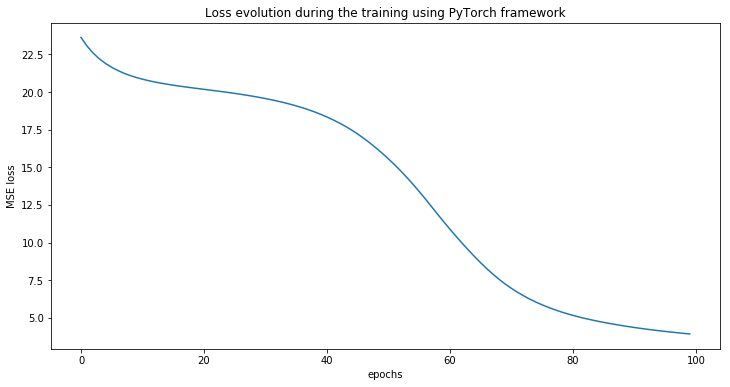

In [57]:
# 100 epochs
plt.subplots(figsize=(12, 6))
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.title('Loss evolution during the training using PyTorch framework')

Text(0.5, 1.0, 'Loss evolution during the training using PyTorch framework')

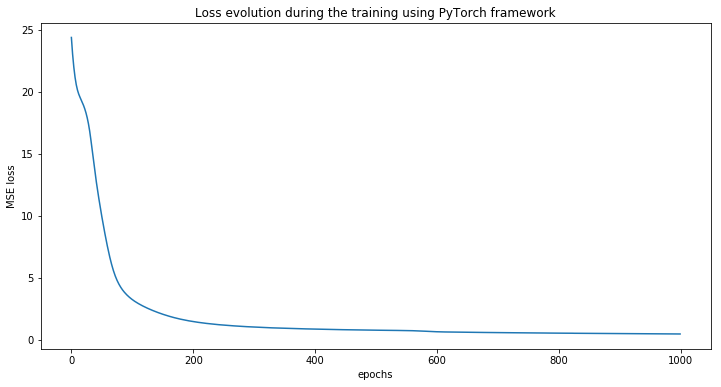

In [62]:
# 1000 epochs
plt.subplots(figsize=(12, 6))
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.title('Loss evolution during the training using PyTorch framework')

## Monitor loss

Text(0.5, 1.0, 'Loss evolution during the training')

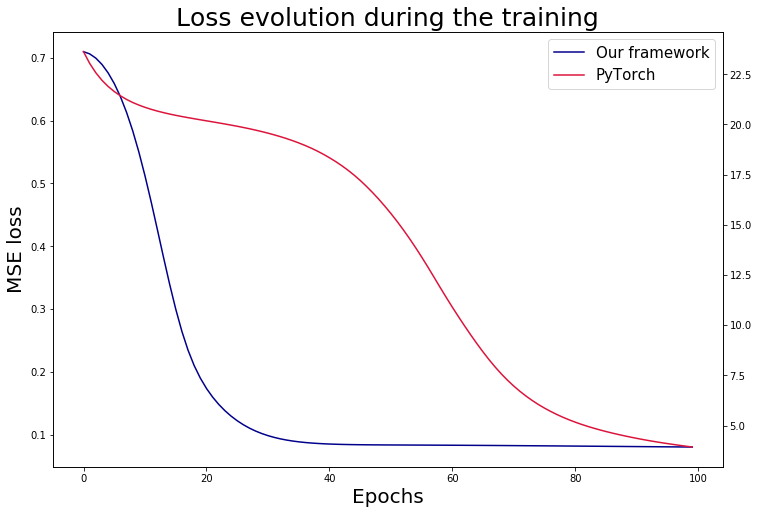

In [84]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

f1 = ax1.plot(df_m1['test_loss'], color='darkblue', label='Our framework')

f2 = ax2.plot(losses, color='crimson', label='PyTorch')

fs = f1 + f2
labs = [l.get_label() for l in fs]
ax1.legend(f1+f2, labs, loc=0, fontsize=15)

ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('MSE loss', fontsize=20)
#ax2.set_ylabel('MSE loss')

plt.title('Loss evolution during the training', fontsize=25)

In [85]:
# Save fig
fig.savefig("losses_evolution.png")

## Monitor accuracy